In [2]:
import os
import glob
import re
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from rasterio.features import geometry_mask
from skimage.segmentation import slic
from skimage.measure import regionprops

In [3]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

image_dir = "E:\\PycharmProjects\\nina\\walrus\\data\\train\\clipped_images"
shapefile_dir = "E:\\PycharmProjects\\nina\\walrus\\data\\train\\clipped_train"
unlabeled_image_dir = "E:\\PycharmProjects\\nina\\walrus\\data\\train\\clipped_unlabeled"
new_walrus_dir = "E:\\PycharmProjects\\nina\\walrus\\data\\walrus_shapefiles"


# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Pair image and shapefile paths based on filenames
def pair_files(image_paths, shapefile_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        if not matching_shapefiles:
            print(f"No matching shapefile found for {image_path}")
            continue

        shapefile_path = matching_shapefiles[0]
        file_pairs[image_path] = shapefile_path
    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths)

# Pair new walrus images with existing images
def pair_walrus_files(new_walrus_paths, image_paths):
    for walrus_path in new_walrus_paths:
        island, date = extract_island_and_date(os.path.basename(walrus_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {walrus_path}")
            continue

        matching_images = [image for image in image_paths if island in image and date in image]
        if not matching_images:
            print(f"No matching image found for {walrus_path}")
            continue

        image_path = matching_images[0]
        file_pairs[image_path] = walrus_path

pair_walrus_files(new_walrus_paths, image_paths + unlabeled_image_paths)

def extract_pixel_features(image_path):
    with rasterio.open(image_path) as src:
        image = src.read().transpose(1, 2, 0)
    
    # Reshape to (n_pixels, n_bands)
    pixel_features = image.reshape(-1, image.shape[2])
    return pixel_features, image.shape[:2]

# Extract features for all images
all_features = []
image_shapes = {}

for image_path in file_pairs.keys():
    features, shape = extract_pixel_features(image_path)
    all_features.append(features)
    image_shapes[image_path] = shape

all_features = np.vstack(all_features)

No matching shapefile found for E:\PycharmProjects\nina\walrus\data\train\clipped_images\pool_20230803_image.tif


In [4]:
# Normalize features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(all_features)

In [8]:
# Perform K-means clustering
n_clusters = 6  # Assuming 6 classes as in the original code
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(normalized_features)

In [9]:
import random
from sklearn.metrics import silhouette_score

# Choose one image randomly
sample_image_path = random.choice(list(file_pairs.keys()))

# Extract features for the sample image
sample_features, _ = extract_pixel_features(sample_image_path)

# Normalize the sample features
sample_normalized_features = scaler.transform(sample_features)

# If the sample is still too large, you can further reduce it
max_sample_size = 10000  # Adjust this value based on your computational resources
if sample_normalized_features.shape[0] > max_sample_size:
    indices = np.random.choice(sample_normalized_features.shape[0], max_sample_size, replace=False)
    sample_normalized_features = sample_normalized_features[indices]

# Perform K-means clustering on the sample
sample_cluster_labels = kmeans.predict(sample_normalized_features)

# Calculate silhouette score for the sample
silhouette_avg = silhouette_score(sample_normalized_features, sample_cluster_labels)
print(f"The average silhouette score for a sample of {sample_image_path} is: {silhouette_avg}")

The average silhouette score for a sample of E:\PycharmProjects\nina\walrus\data\train\clipped_images\pal_20230720_image.tif is: 0.38003000672716986


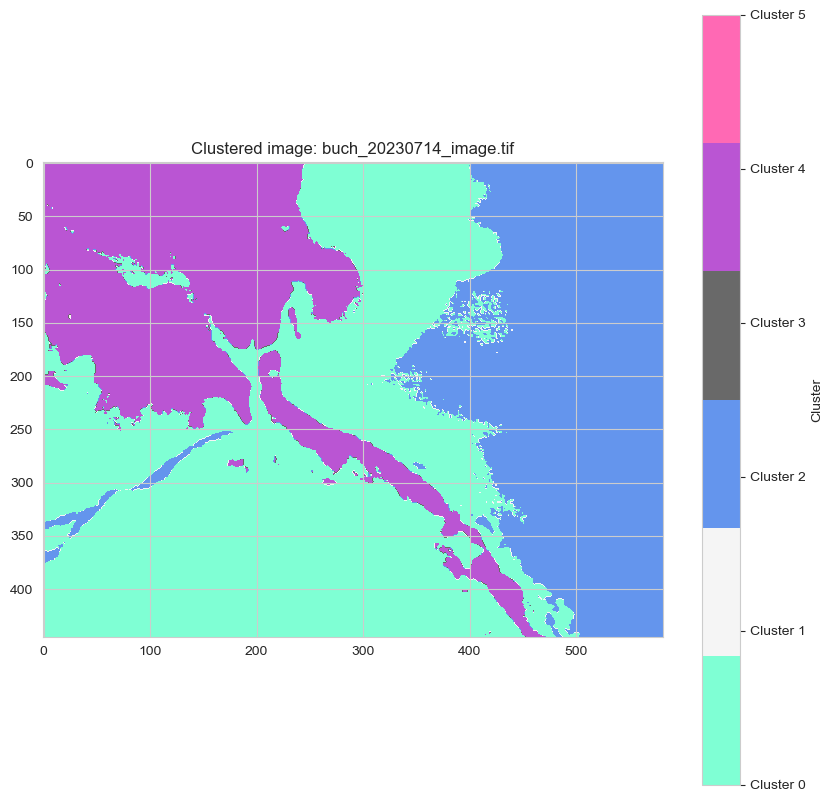

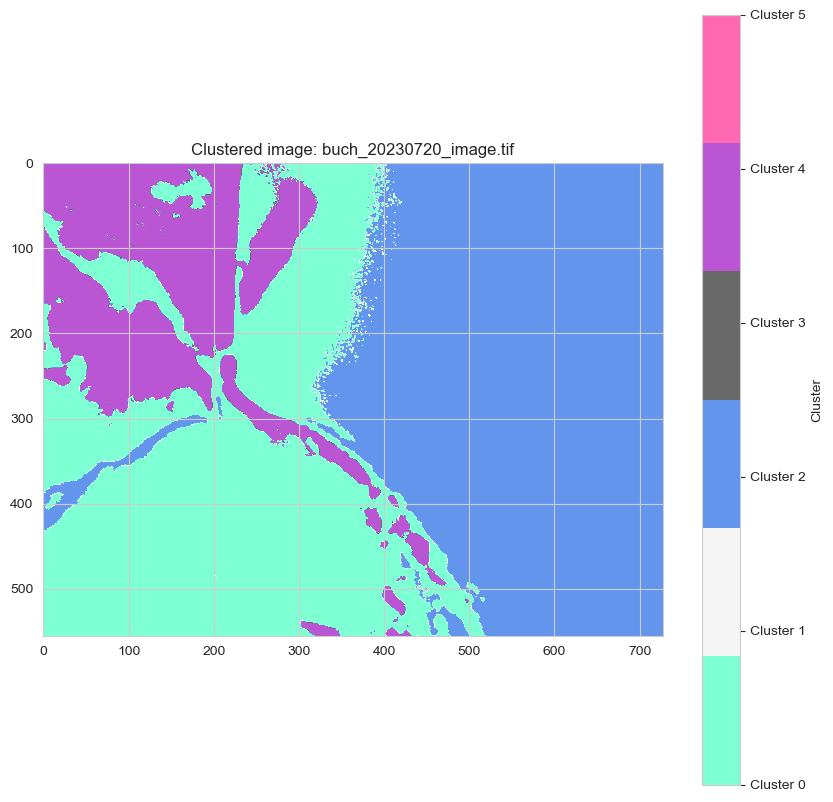

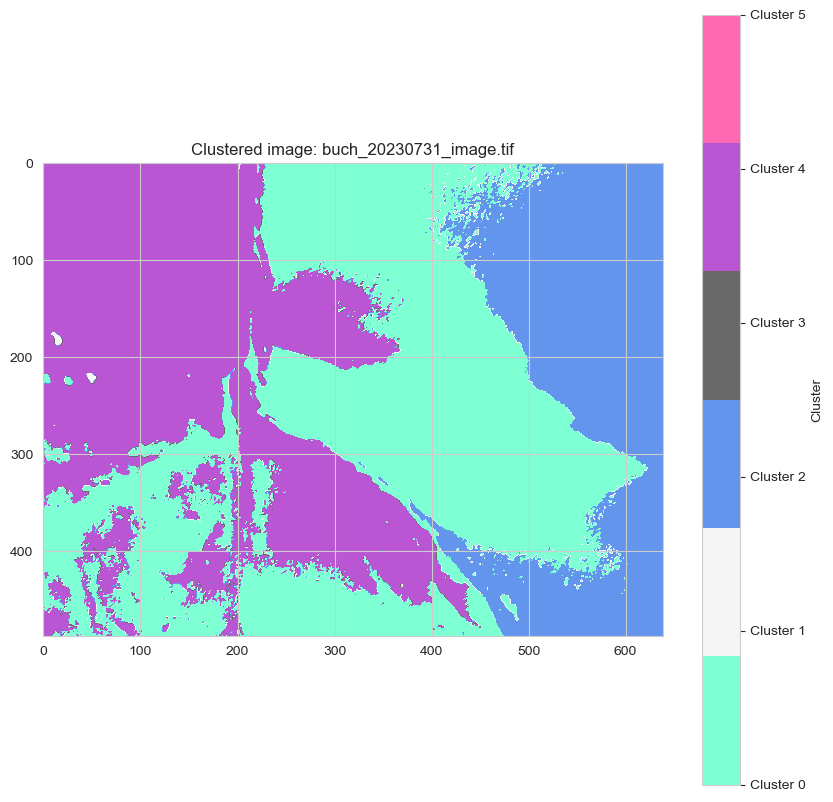

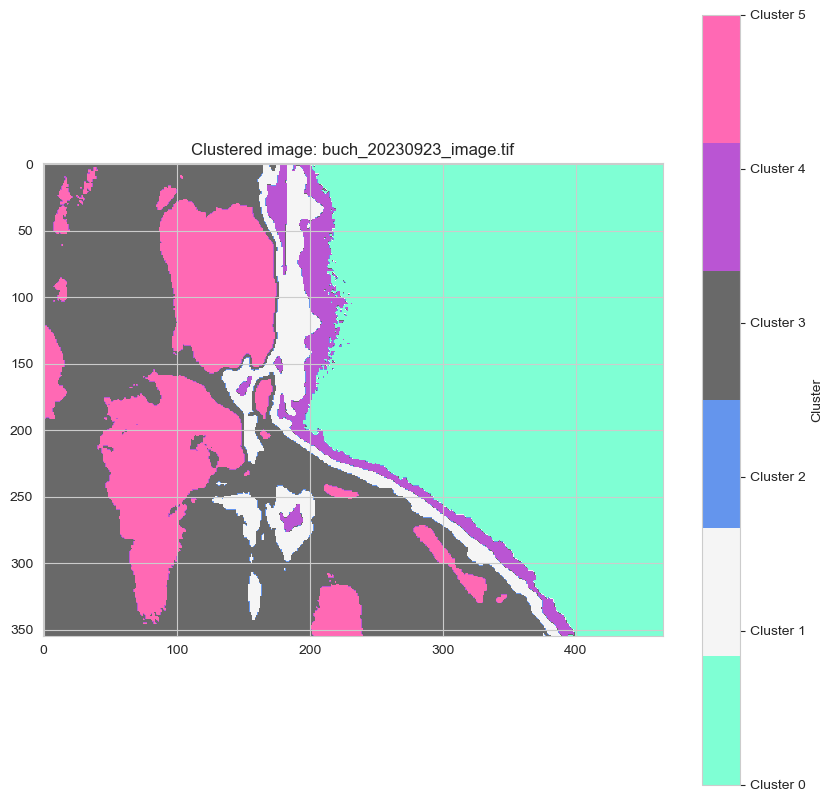

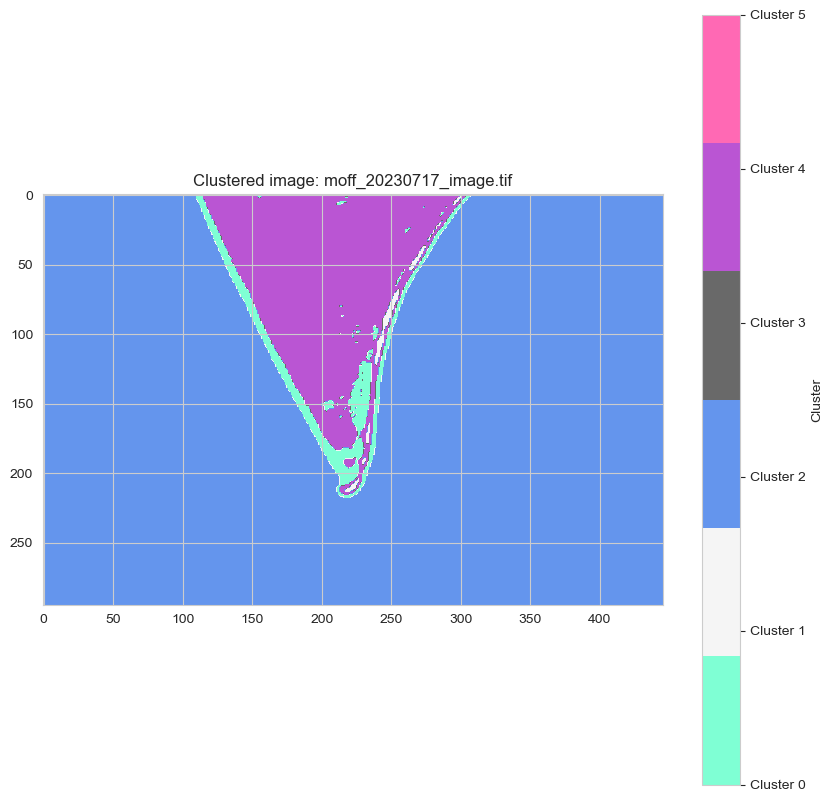

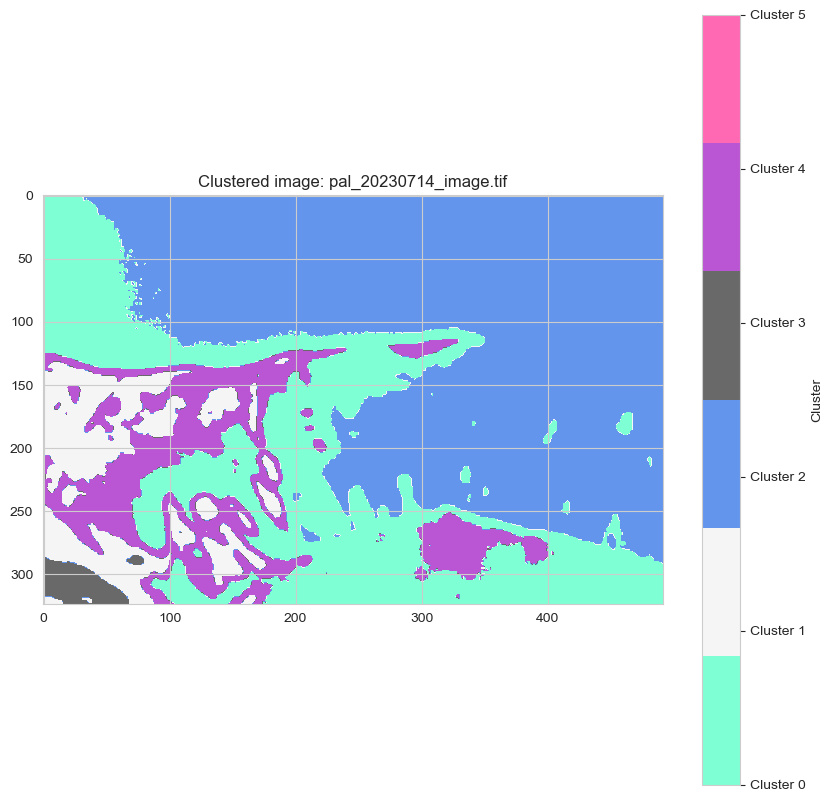

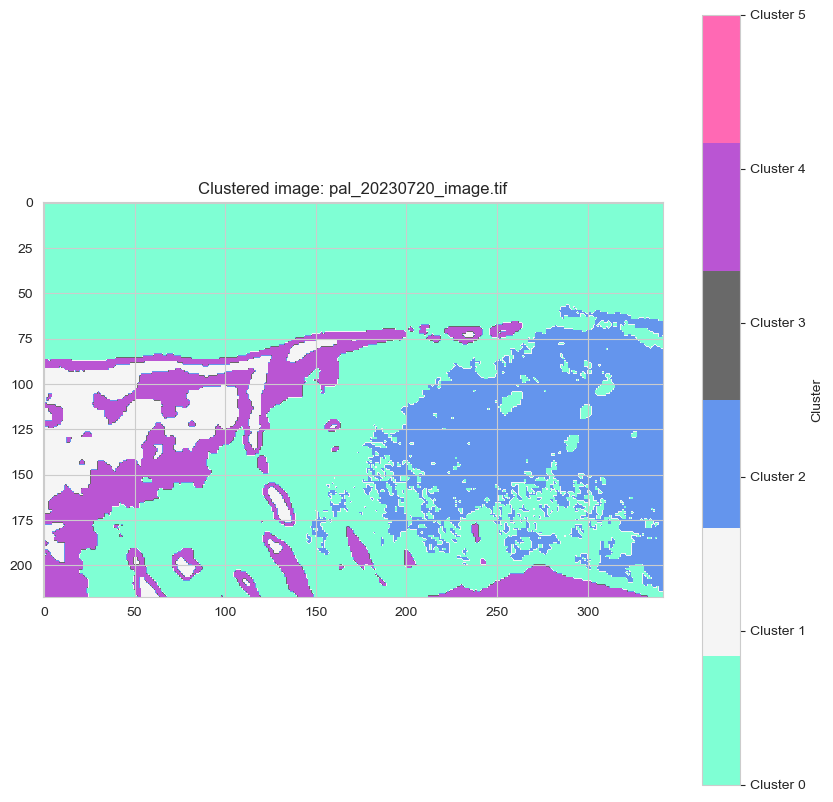

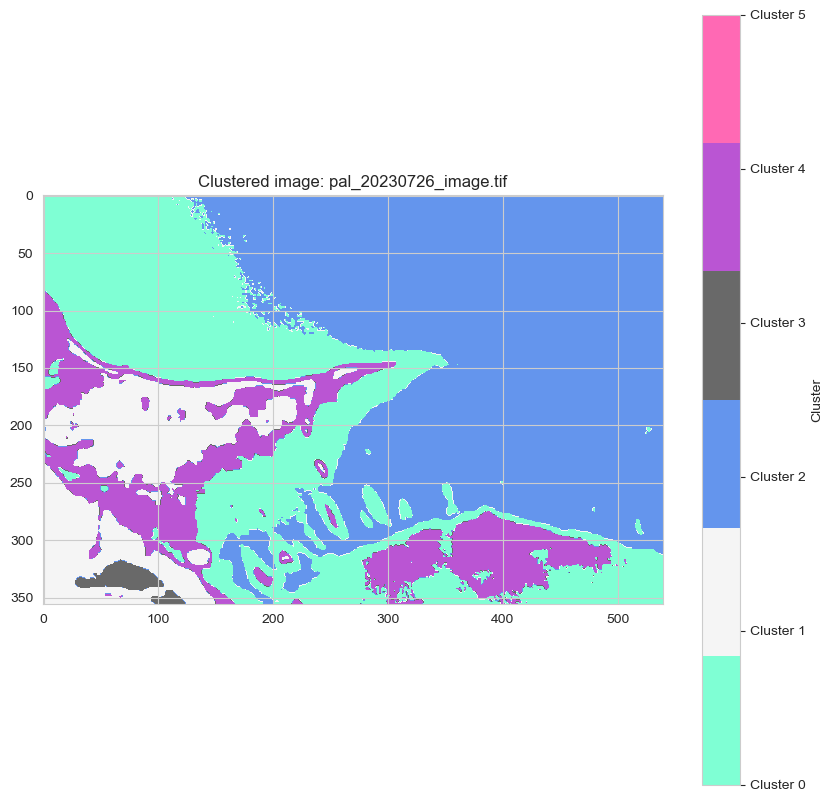

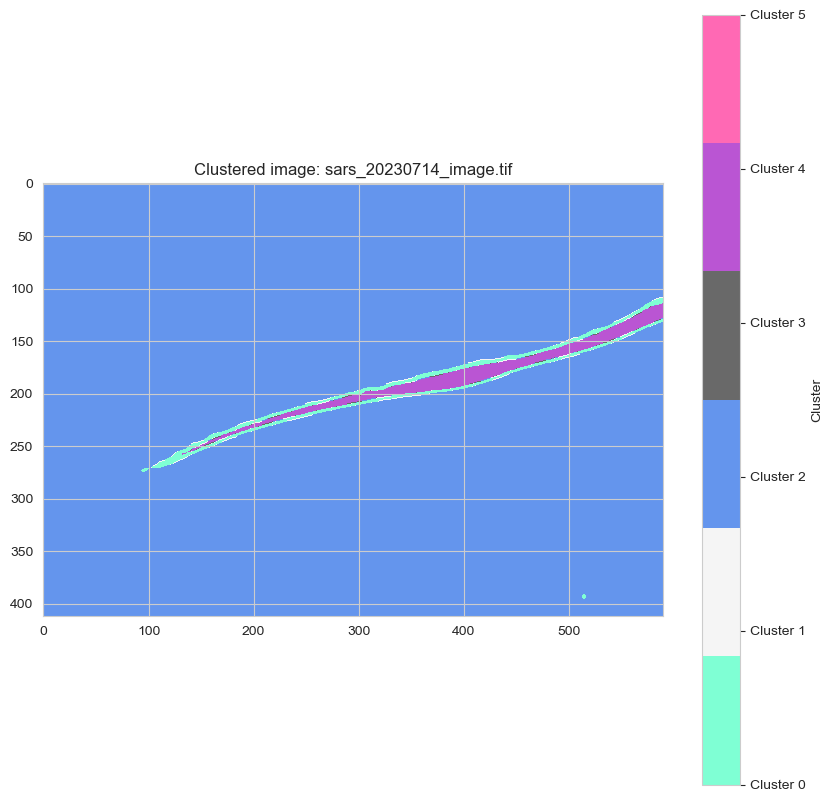

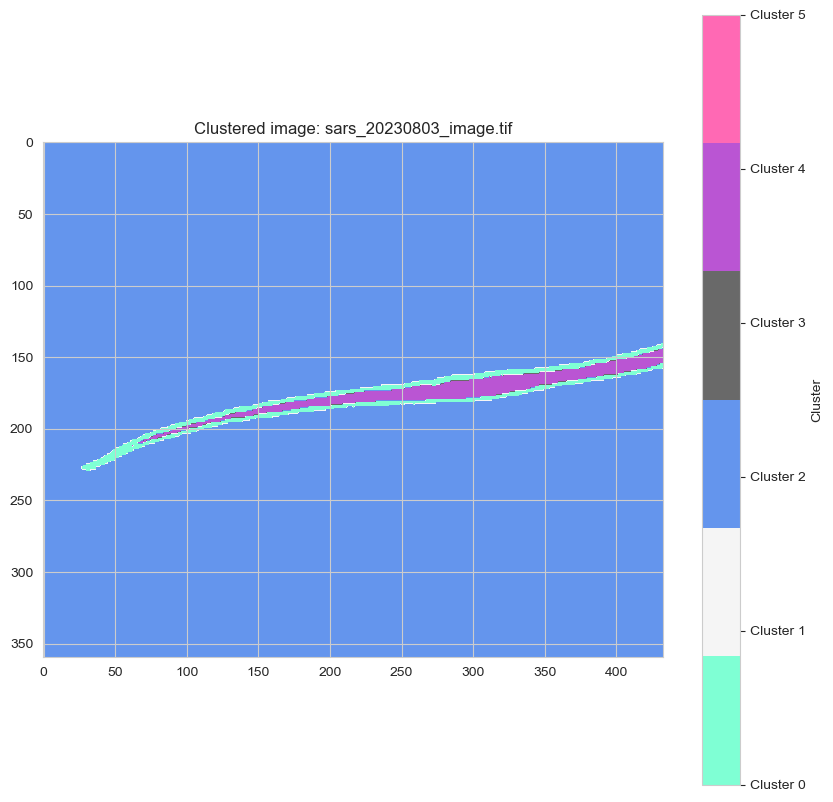

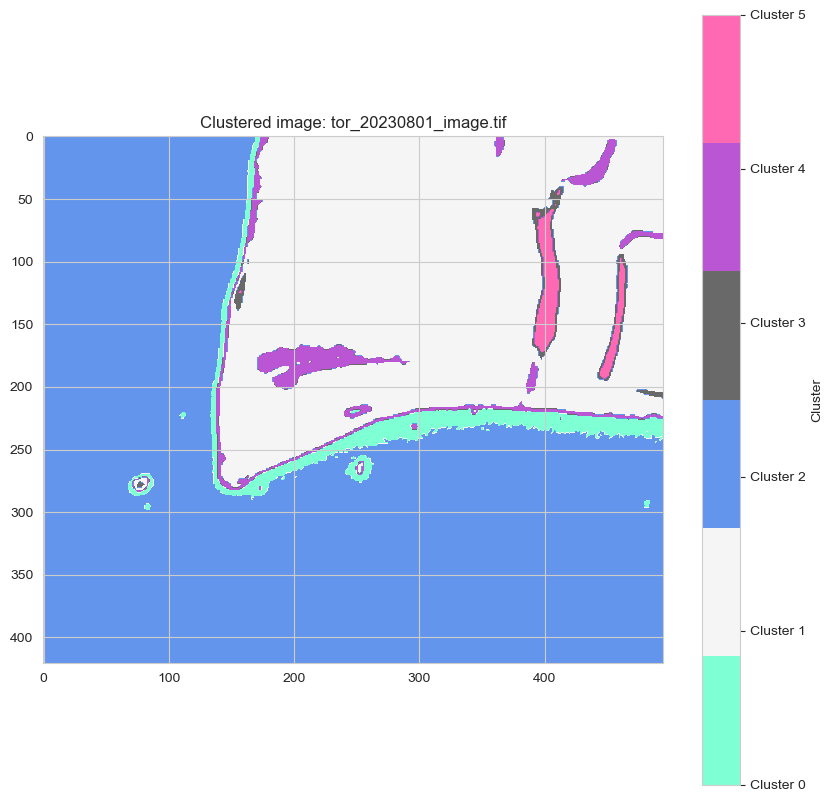

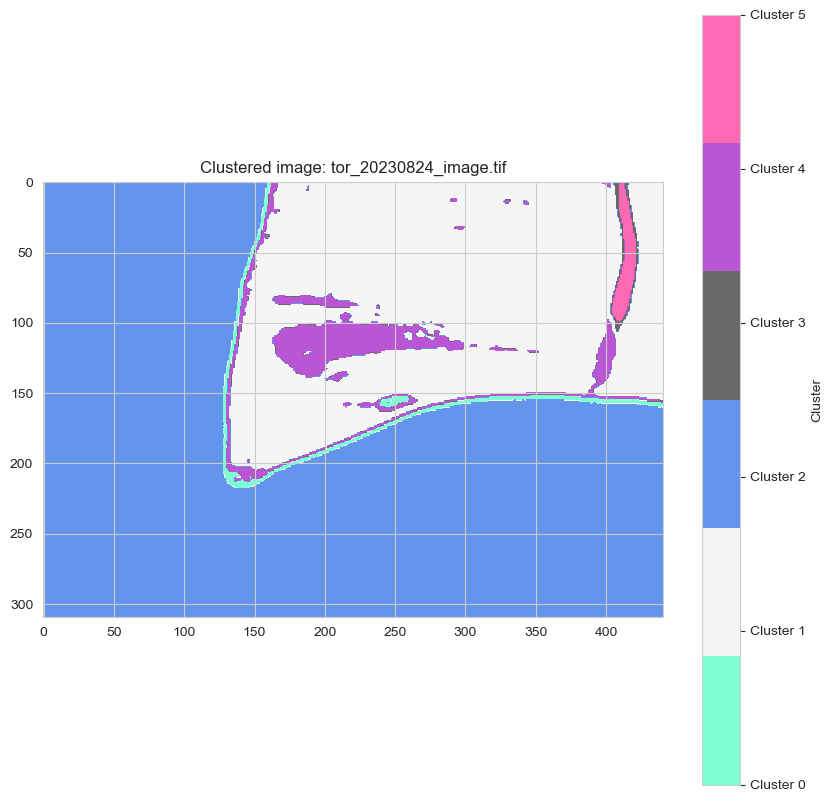

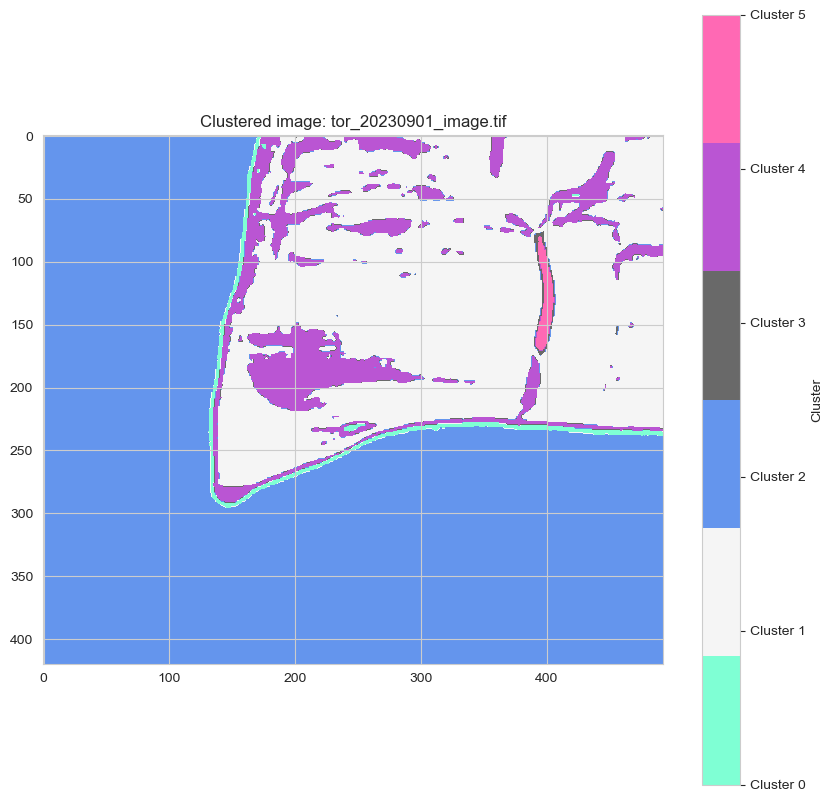

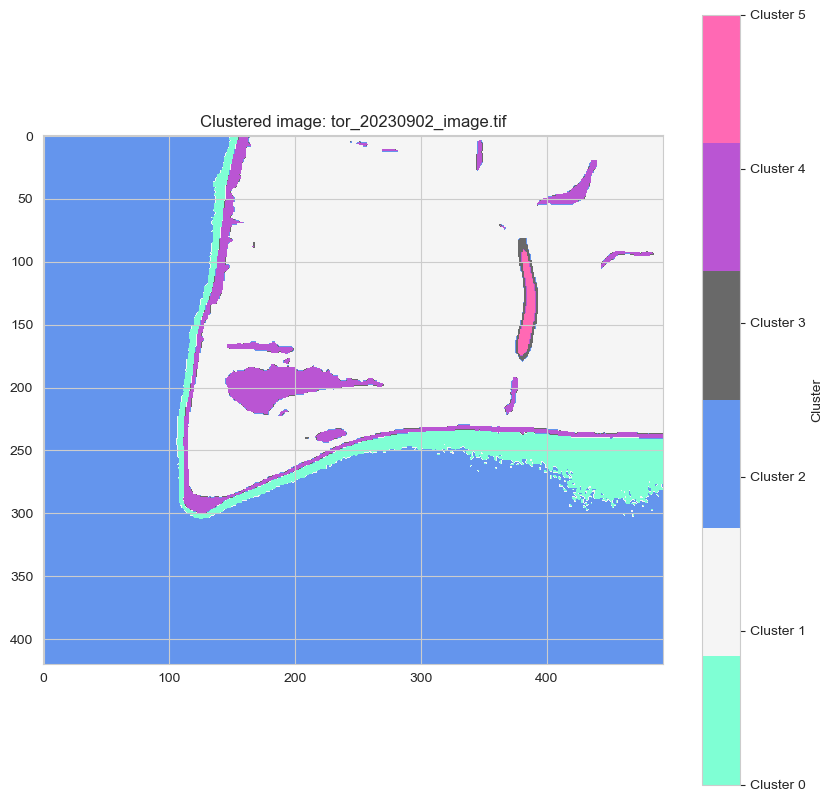

Tentative cluster to class mapping:
Cluster 2: ocean
Cluster 0: rock
Cluster 4: ice
Cluster 3: ice
Cluster 1: freshwater


In [10]:
# Function to predict clusters for a given image
def predict_image_clusters_pixel(image_path, kmeans, scaler):
    features, shape = extract_pixel_features(image_path)
    normalized_features = scaler.transform(features)
    predictions = kmeans.predict(normalized_features)
    return predictions.reshape(shape)

# Predict clusters for all images
predicted_images = {}
for image_path in file_pairs.keys():
    predicted_images[image_path] = predict_image_clusters_pixel(image_path, kmeans, scaler)

# Define a color map for the clusters
cluster_colors = ['aquamarine', 'whitesmoke', 'cornflowerblue', 'dimgrey', 'mediumorchid', 'hotpink']
cmap = mcolors.ListedColormap(cluster_colors[:n_clusters])

# Plot the clustered images
for image_path, predicted_image in predicted_images.items():
    plt.figure(figsize=(10, 10))
    plt.title(f"Clustered image: {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=n_clusters-1)
    
    cbar = plt.colorbar(ticks=range(n_clusters), label='Cluster')
    cbar.ax.set_yticklabels([f'Cluster {i}' for i in range(n_clusters)])
    
    plt.show()

# Optional: Try to match clusters to original classes
# This is a simple approach and may not be accurate
cluster_to_class = {}
for image_path, shapefile_path in file_pairs.items():
    predicted_image = predicted_images[image_path]
    
    with rasterio.open(image_path) as src:
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    mask = geometry_mask([polygon for polygon in gdf['geometry']], 
                         out_shape=predicted_image.shape, 
                         transform=transform, invert=True)
    
    for label in gdf['label'].unique():
        label_mask = gdf['label'] == label
        label_pixels = predicted_image[mask & geometry_mask([polygon for polygon in gdf.loc[label_mask, 'geometry']], 
                                                            out_shape=predicted_image.shape, 
                                                            transform=transform, invert=True)]
        if len(label_pixels) > 0:
            most_common_cluster = np.bincount(label_pixels).argmax()
            if most_common_cluster not in cluster_to_class:
                cluster_to_class[most_common_cluster] = label

print("Tentative cluster to class mapping:")
for cluster, label in cluster_to_class.items():
    print(f"Cluster {cluster}: {label}")

semi - supervised, using spectral infomation 

In [14]:
import os
import glob
import re
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from rasterio.features import geometry_mask
from rasterio.mask import mask
import random

In [15]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

def pair_files(image_paths, shapefile_paths, walrus_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue
        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        matching_walrus = [walrus for walrus in walrus_paths if island in walrus and date in walrus]
        
        general_shapefile = matching_shapefiles[0] if matching_shapefiles else None
        walrus_shapefile = matching_walrus[0] if matching_walrus else None
        
        if general_shapefile or walrus_shapefile:
            file_pairs[image_path] = (general_shapefile, walrus_shapefile)
    return file_pairs

file_pairs = pair_files(image_paths + unlabeled_image_paths, shapefile_paths, new_walrus_paths)

def extract_features_labels(image_path, general_shapefile, walrus_shapefile):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = []
    labels = []

    if general_shapefile:
        gdf = gpd.read_file(general_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            features.extend(feature_pixels.T)
            labels.extend([row['label']] * feature_pixels.shape[1])

    if walrus_shapefile:
        gdf = gpd.read_file(walrus_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            features.extend(feature_pixels.T)
            labels.extend([row['label']] * feature_pixels.shape[1])

    return np.array(features), np.array(labels)

def get_dataset(file_pairs):
    features = []
    labels = []

    for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
        img_features, img_labels = extract_features_labels(image_path, general_shapefile, walrus_shapefile)
        features.append(img_features)
        labels.append(img_labels)

    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels

features, labels = get_dataset(file_pairs)

In [16]:
# Calculate spectral profiles
unique_labels = np.unique(labels)
spectral_profiles = {}

for label in unique_labels:
    label_features = features[labels == label]
    spectral_profiles[label] = np.mean(label_features, axis=0)

In [17]:
# Normalize features and spectral profiles
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)
normalized_centroids = scaler.transform(np.array(list(spectral_profiles.values())))

In [18]:
# Perform K-means clustering with initial centroids
n_clusters = len(spectral_profiles)
kmeans = KMeans(n_clusters=n_clusters, init=normalized_centroids, n_init=1, random_state=42)
cluster_labels = kmeans.fit_predict(normalized_features)

In [21]:
import numpy as np
from sklearn.metrics import silhouette_score

# Choose one image randomly for metrics
sample_image_path = random.choice(list(file_pairs.keys()))
with rasterio.open(sample_image_path) as src:
    sample_image = src.read().transpose(1, 2, 0)

# Reshape the image and select a random subset of pixels
sample_features = sample_image.reshape(-1, sample_image.shape[2])
n_samples = min(5000, sample_features.shape[0])  # Use 5000 pixels or all pixels if less
random_indices = np.random.choice(sample_features.shape[0], n_samples, replace=False)
sample_features_subset = sample_features[random_indices]

# Normalize and cluster the subset
sample_normalized_features = scaler.transform(sample_features_subset)
sample_cluster_labels = kmeans.predict(sample_normalized_features)

# Calculate silhouette score for the sample subset
silhouette_avg = silhouette_score(sample_normalized_features, sample_cluster_labels)
print(f"The average silhouette score for {os.path.basename(sample_image_path)} (using {n_samples} pixels) is: {silhouette_avg}")

# For visualization, you can still use all pixels if needed
full_sample_normalized_features = scaler.transform(sample_features)
full_sample_cluster_labels = kmeans.predict(full_sample_normalized_features)

The average silhouette score for buch_20230720_image.tif (using 5000 pixels) is: 0.37631639285386853


In [23]:
# For visualization, you can still use all pixels if needed
full_sample_normalized_features = scaler.transform(sample_features)
full_sample_cluster_labels = kmeans.predict(full_sample_normalized_features)



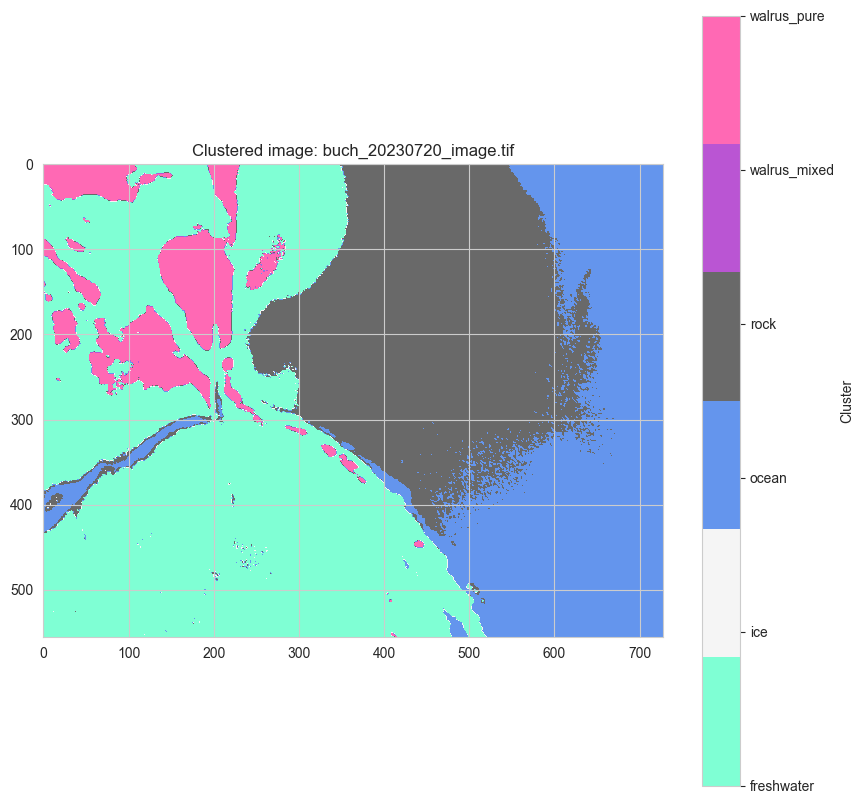

Cluster to class mapping:
Cluster 0: freshwater
Cluster 1: ice
Cluster 2: ocean
Cluster 3: rock
Cluster 4: walrus_mixed
Cluster 5: walrus_pure


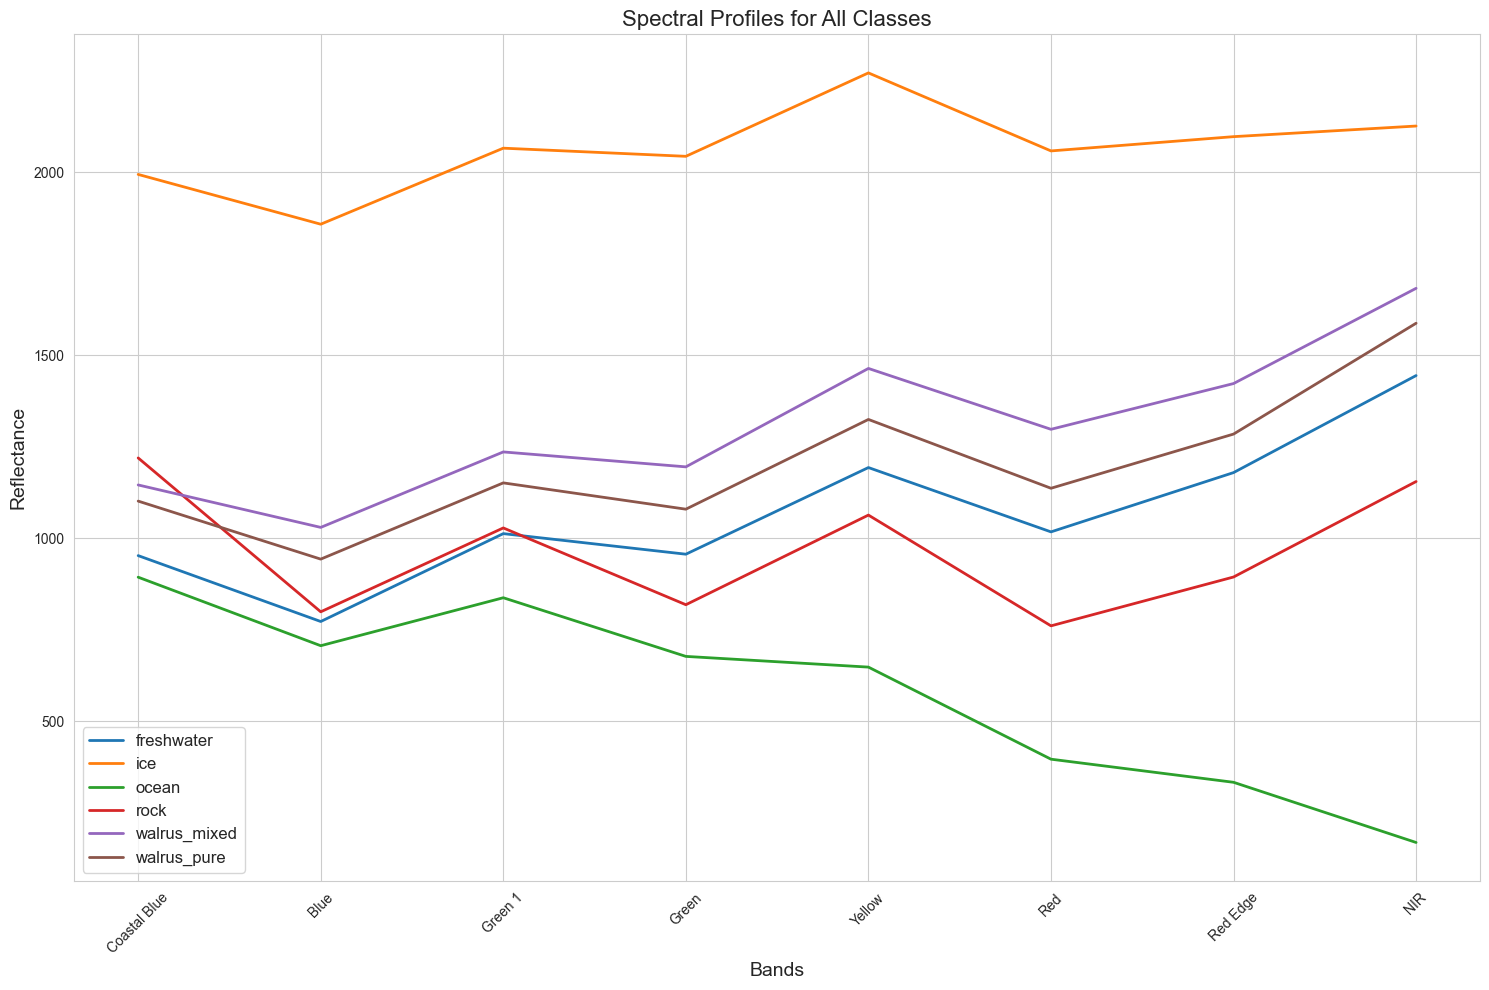

In [24]:
# Define a color map for the clusters
cluster_colors = ['aquamarine', 'whitesmoke', 'cornflowerblue', 'dimgrey', 'mediumorchid', 'hotpink']
cmap = mcolors.ListedColormap(cluster_colors[:n_clusters])

# Plot the clustered image
predicted_image = full_sample_cluster_labels.reshape(sample_image.shape[:2])
plt.figure(figsize=(10, 10))
plt.title(f"Clustered image: {os.path.basename(sample_image_path)}")
plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=n_clusters-1)
cbar = plt.colorbar(ticks=range(n_clusters), label='Cluster')
cbar.ax.set_yticklabels(list(spectral_profiles.keys()))
plt.show()

# Optional: Try to match clusters to original classes
cluster_to_class = {}
for cluster, (class_name, profile) in enumerate(spectral_profiles.items()):
    cluster_to_class[cluster] = class_name

print("Cluster to class mapping:")
for cluster, label in cluster_to_class.items():
    print(f"Cluster {cluster}: {label}")

# Plot spectral signatures for all classes
plt.figure(figsize=(15, 10))
band_names = ['Coastal Blue', 'Blue', 'Green 1', 'Green', 'Yellow', 'Red', 'Red Edge', 'NIR']
for label, profile in spectral_profiles.items():
    plt.plot(range(len(profile)), profile, label=label, linewidth=2)

plt.xlabel('Bands', fontsize=14)
plt.ylabel('Reflectance', fontsize=14)
plt.title('Spectral Profiles for All Classes', fontsize=16)
plt.xticks(range(len(band_names)), band_names, rotation=45)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

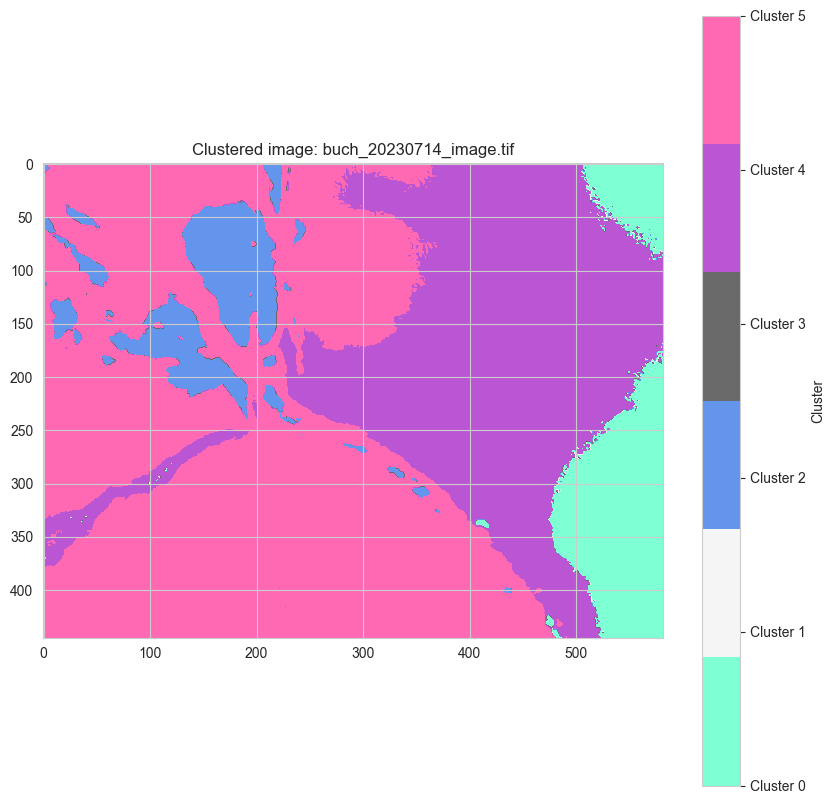

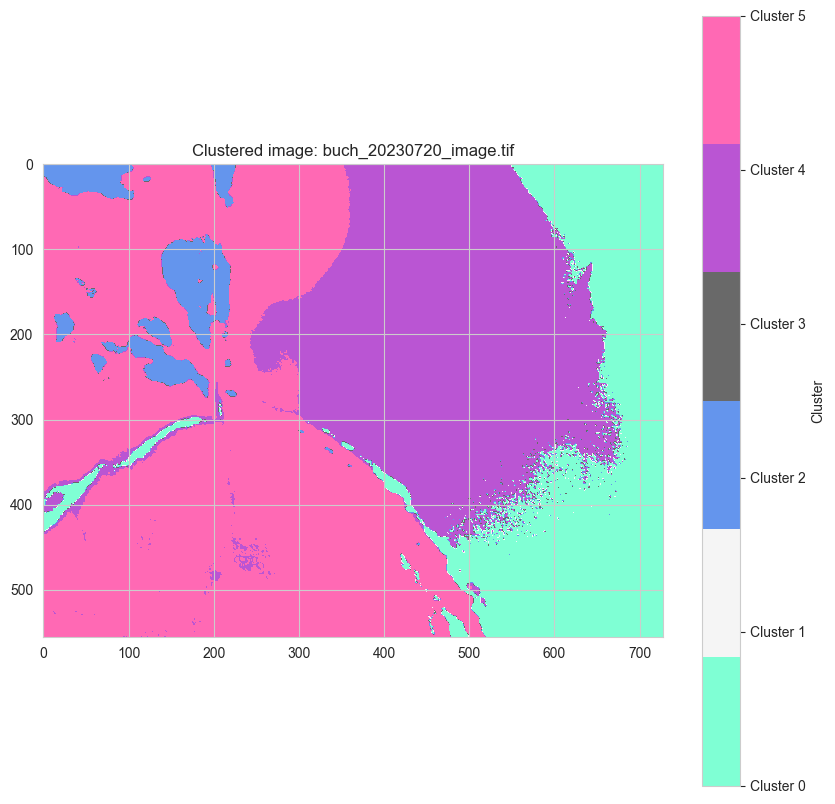

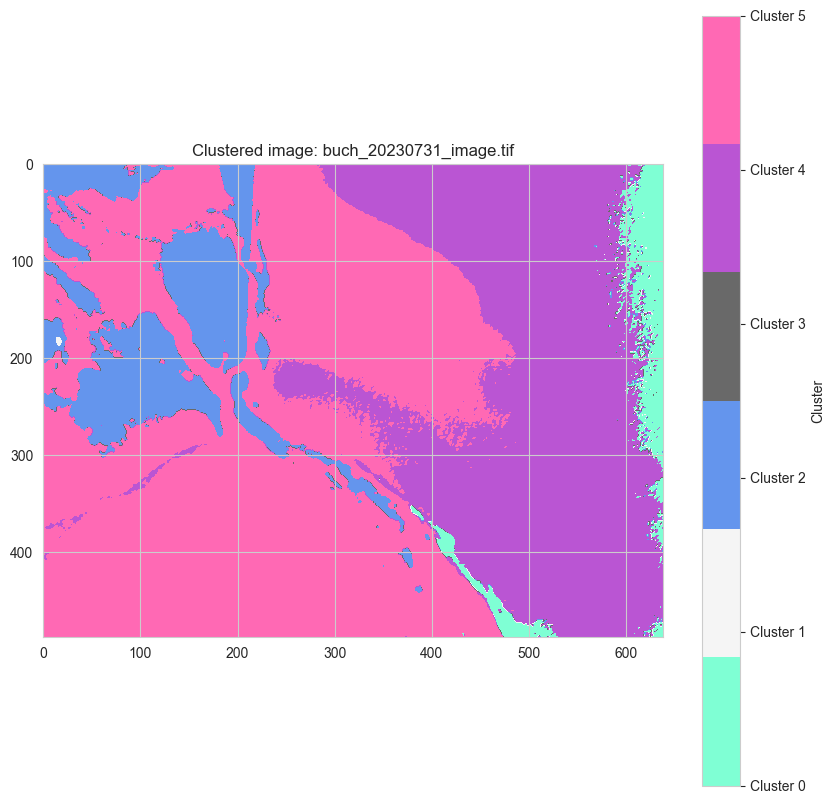

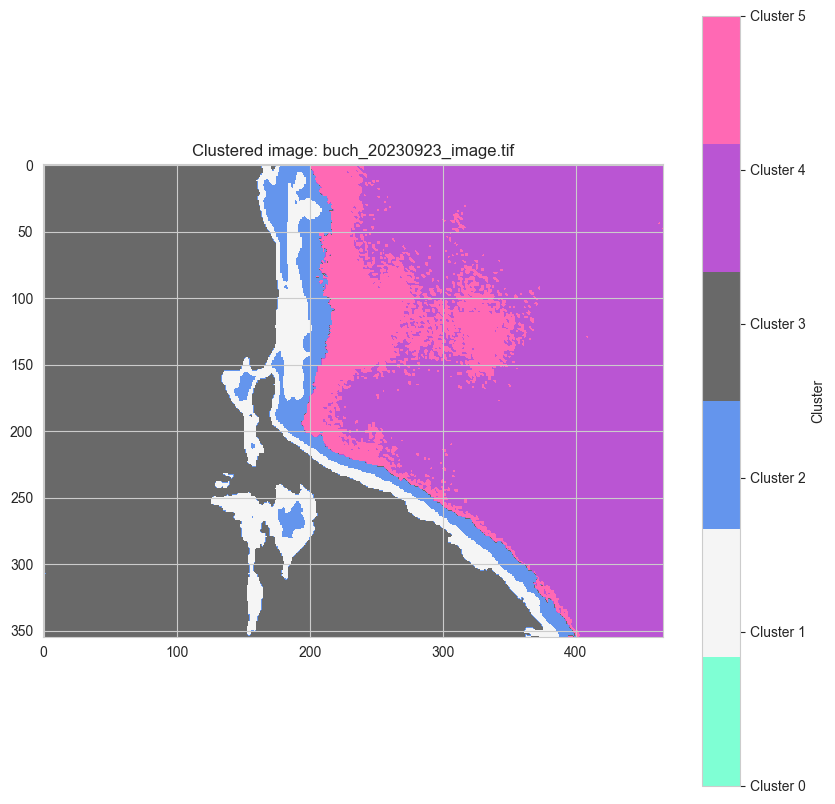

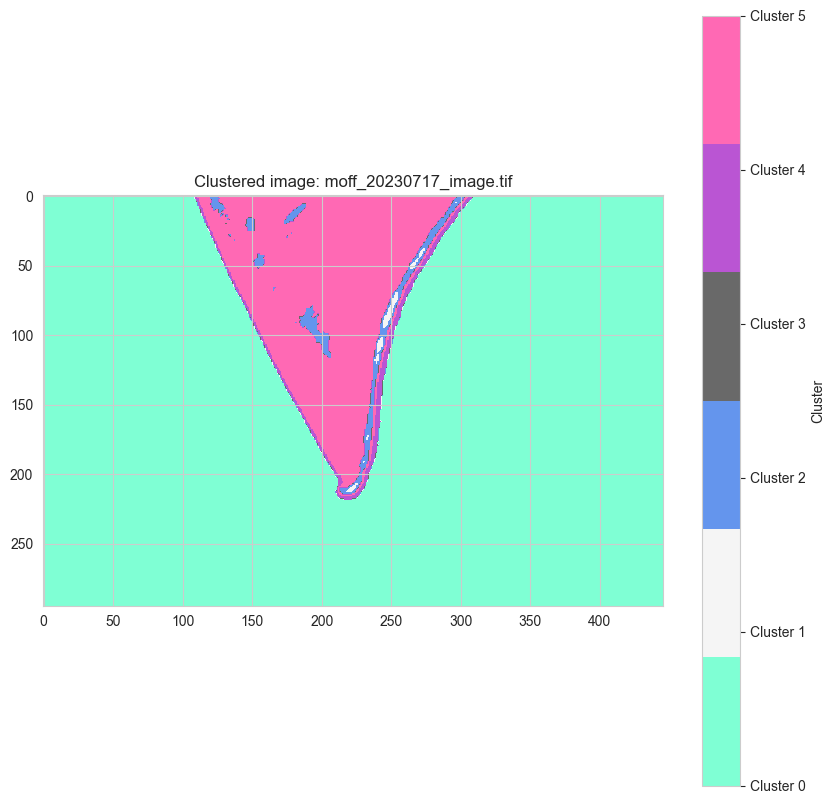

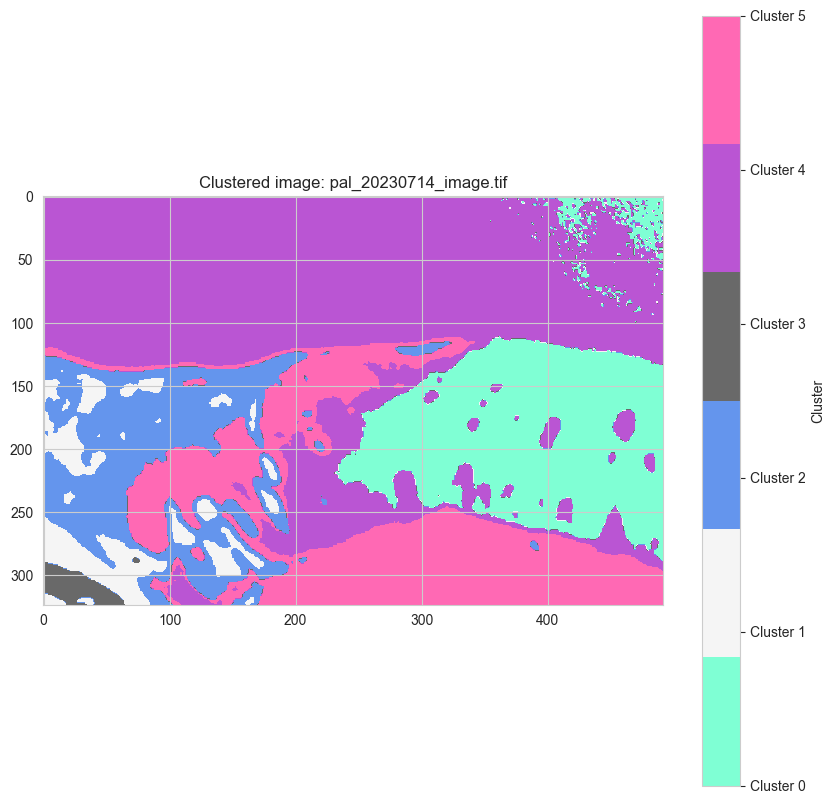

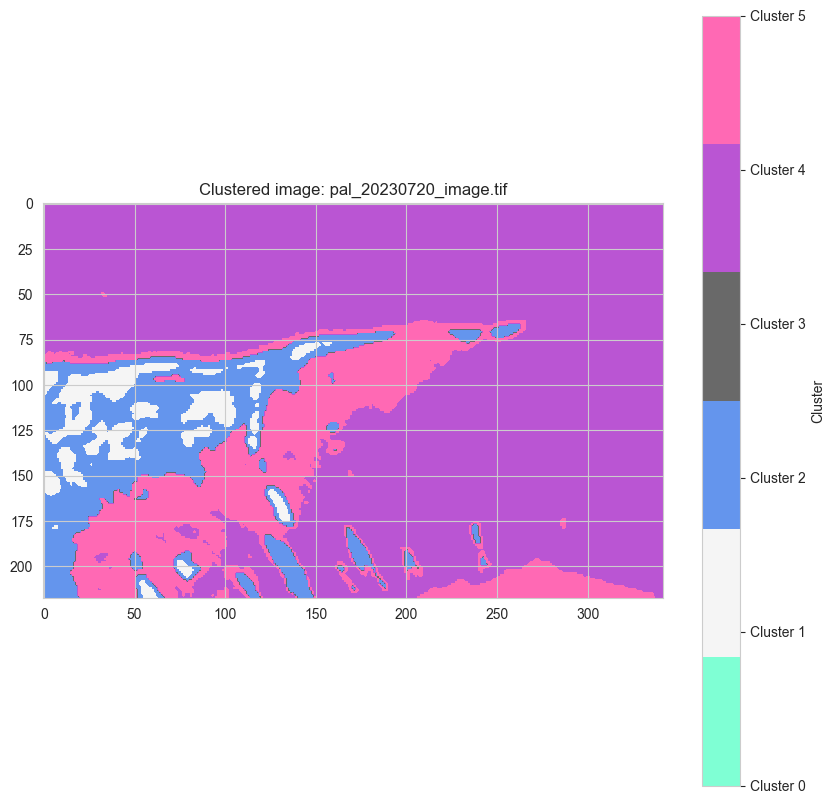

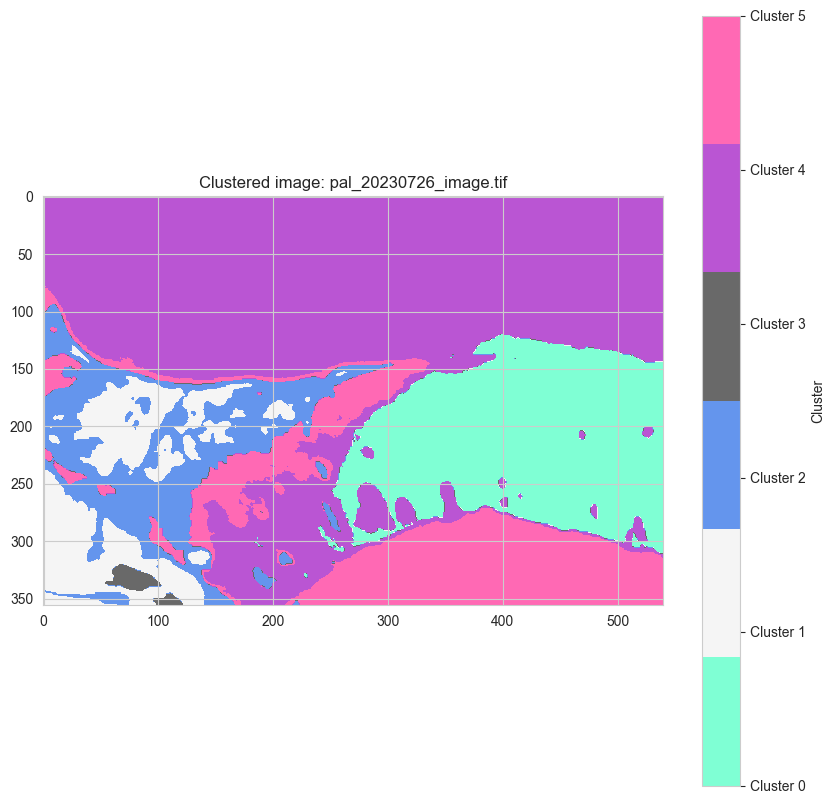

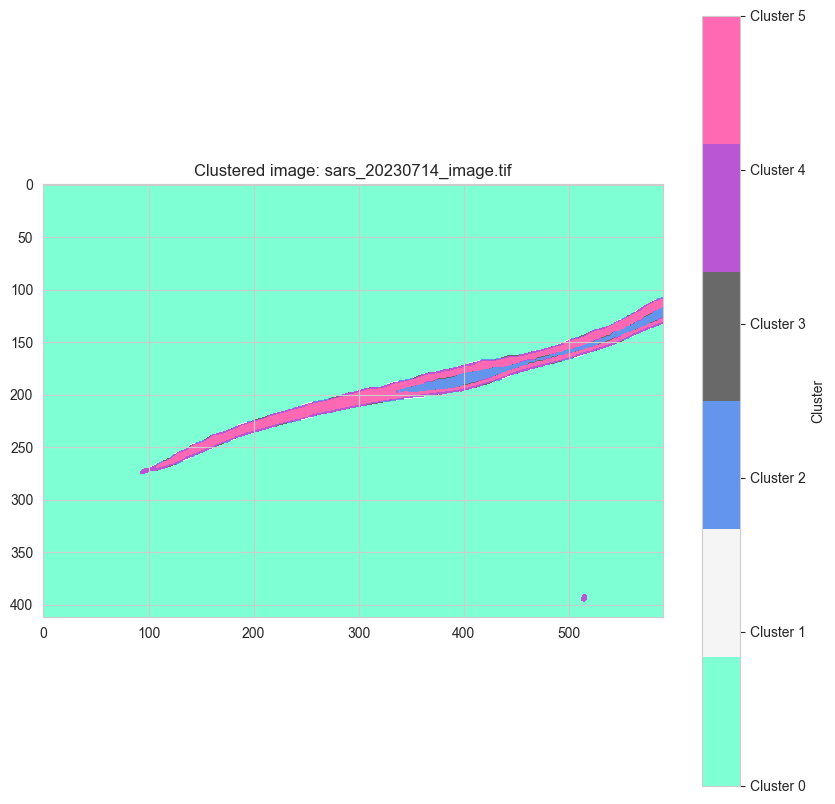

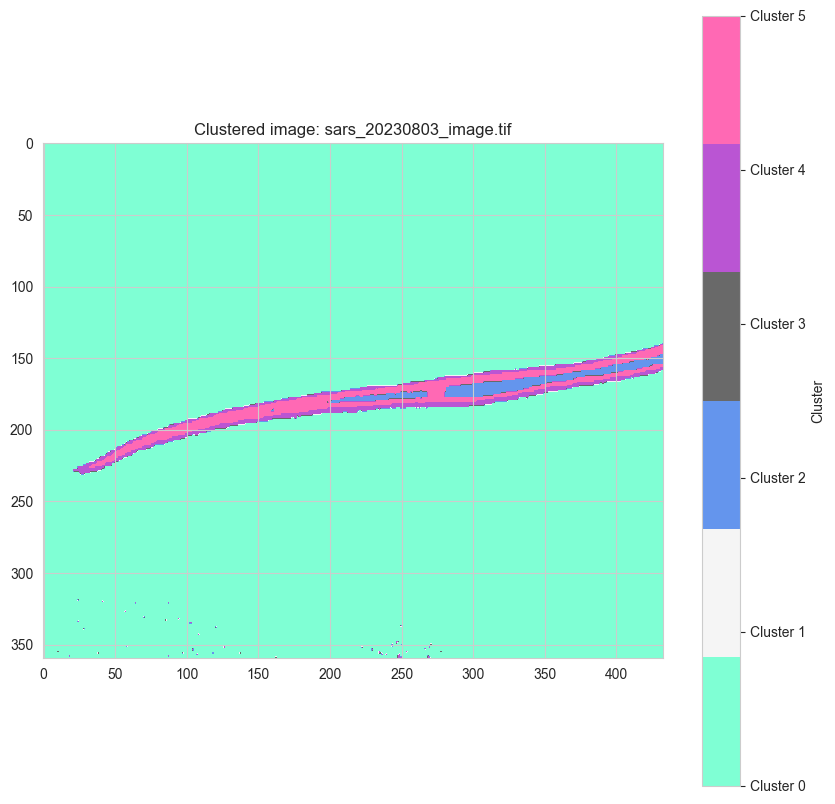

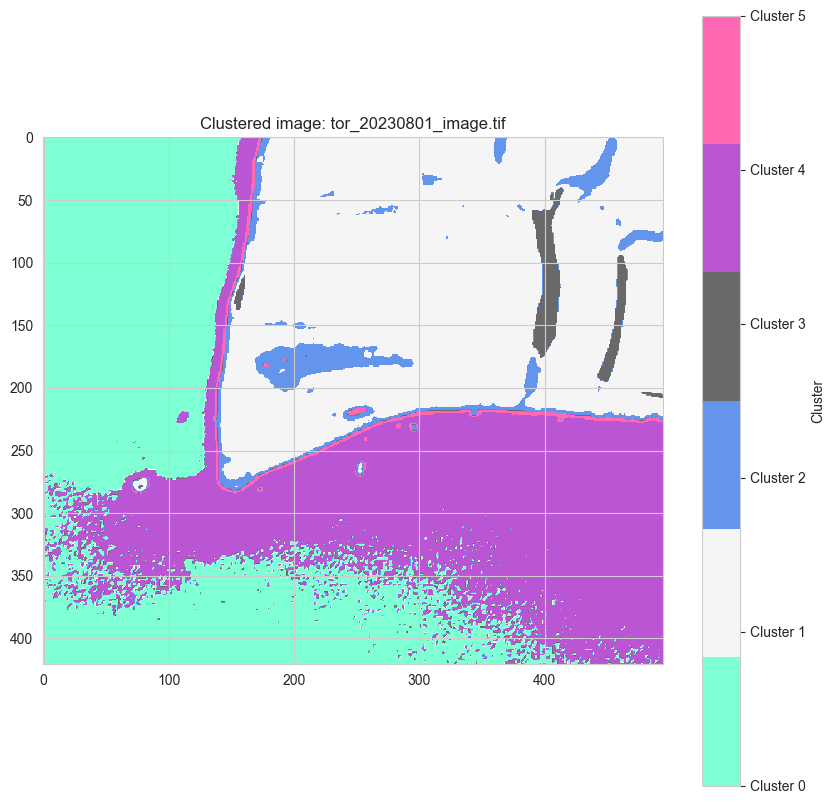

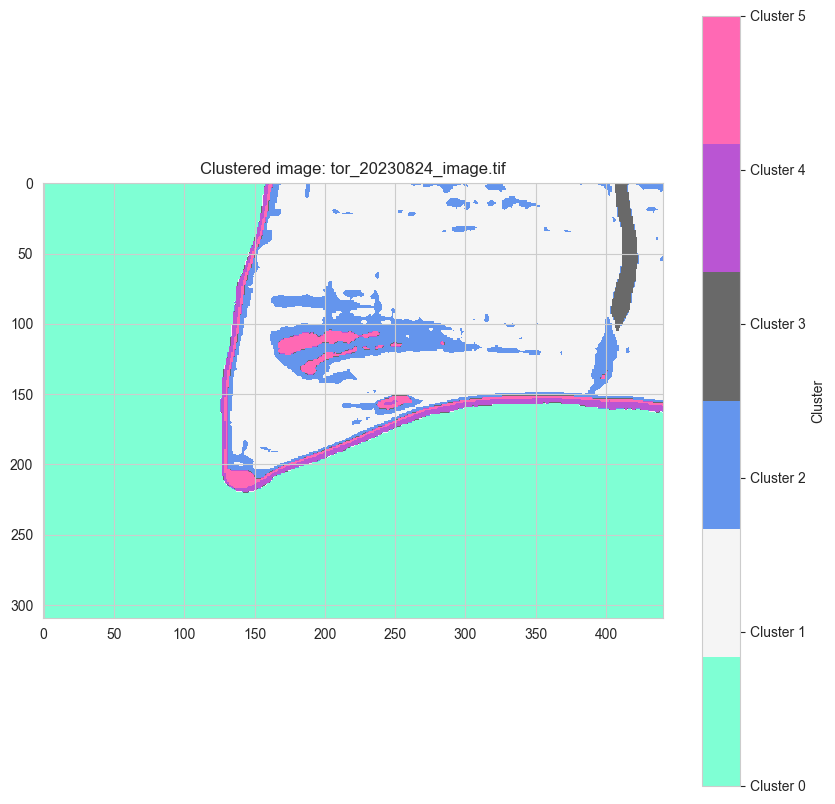

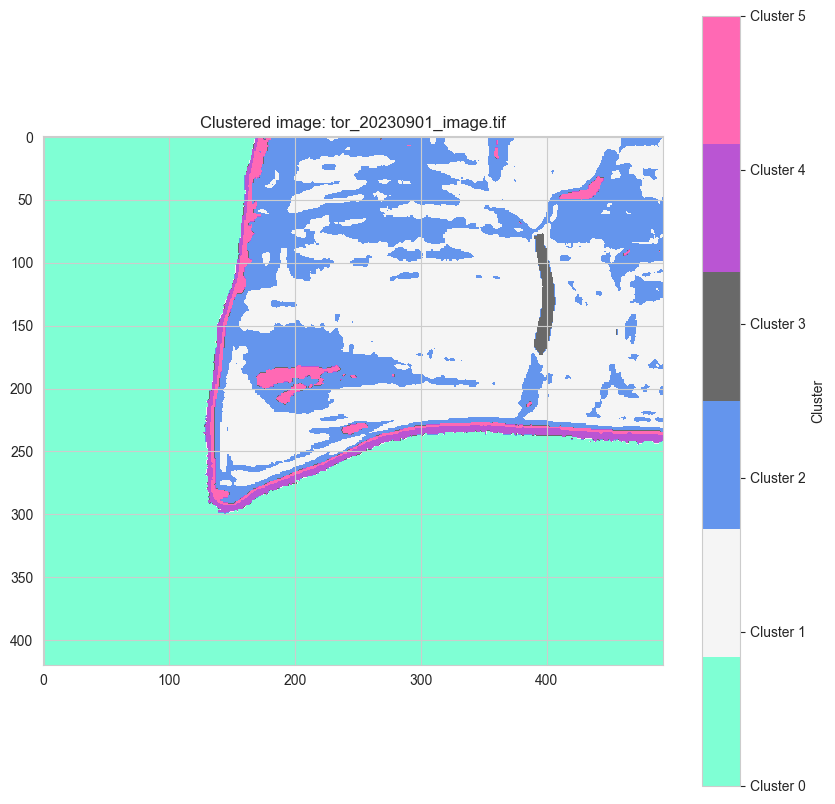

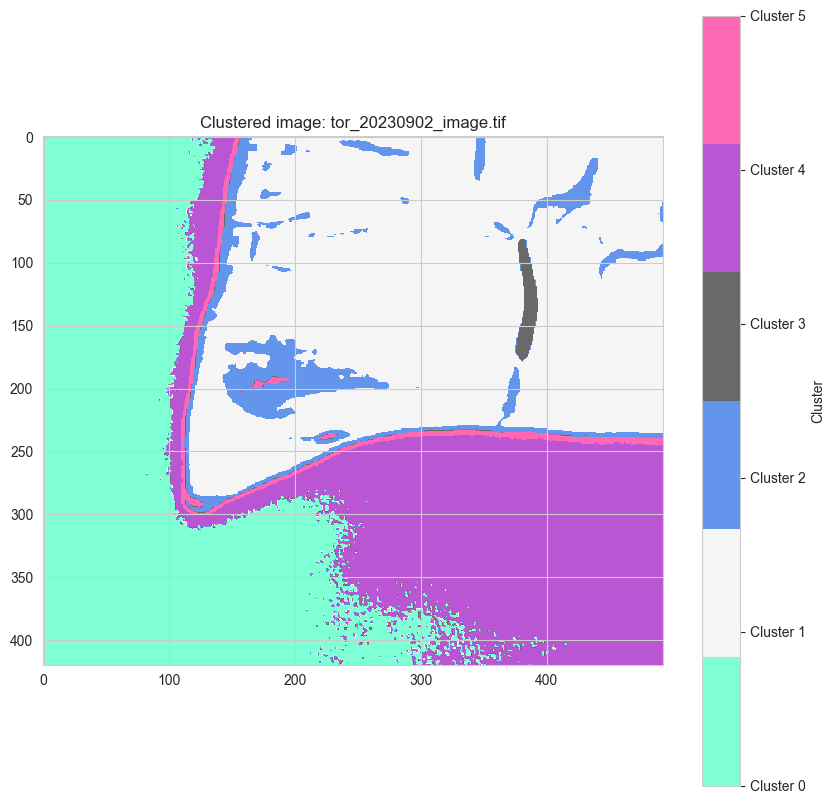

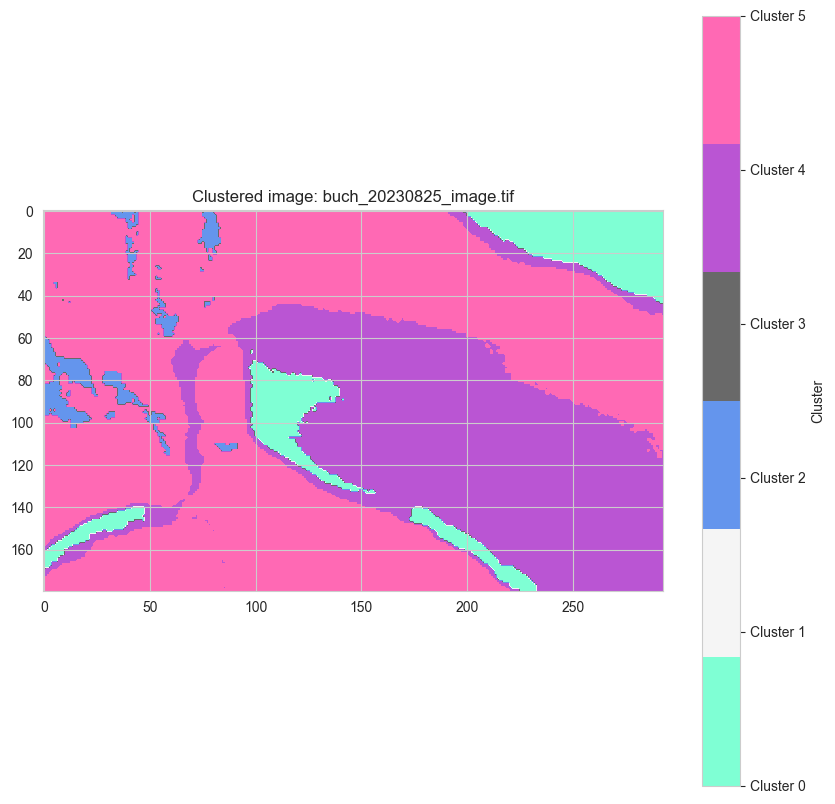

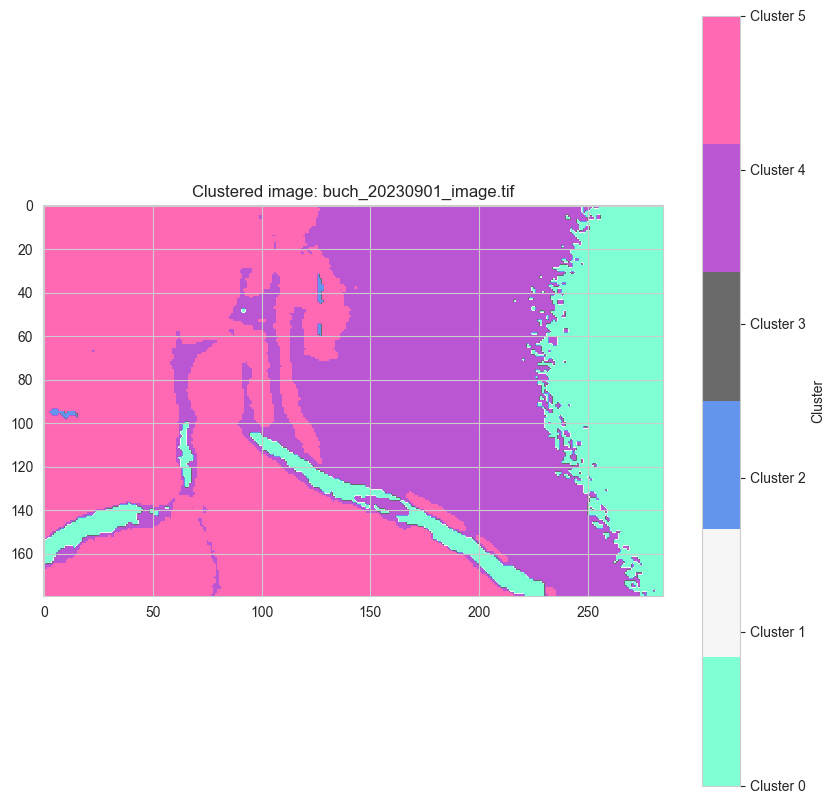

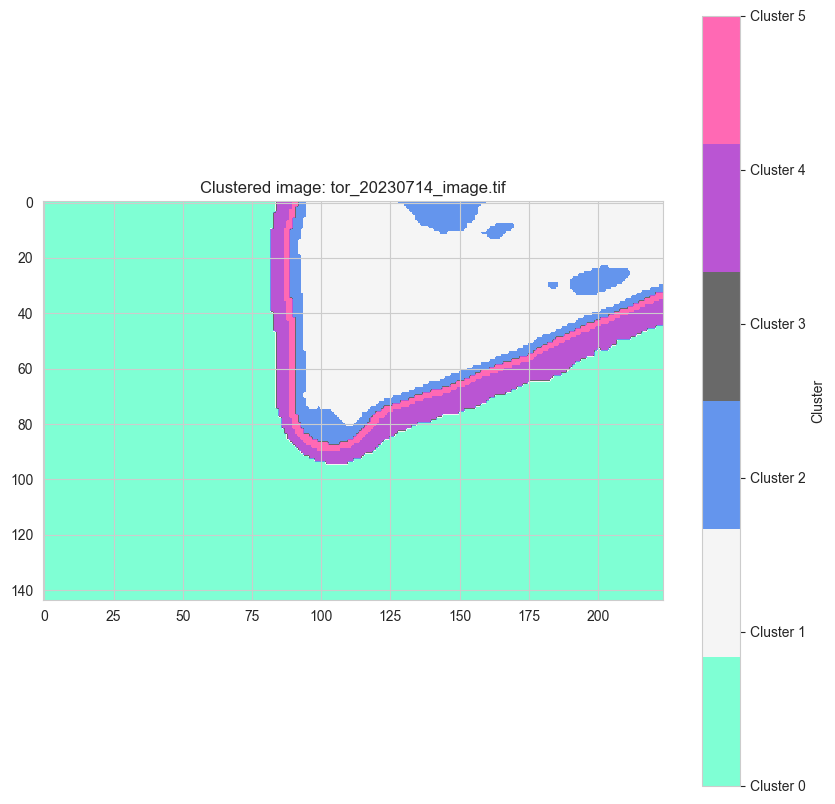

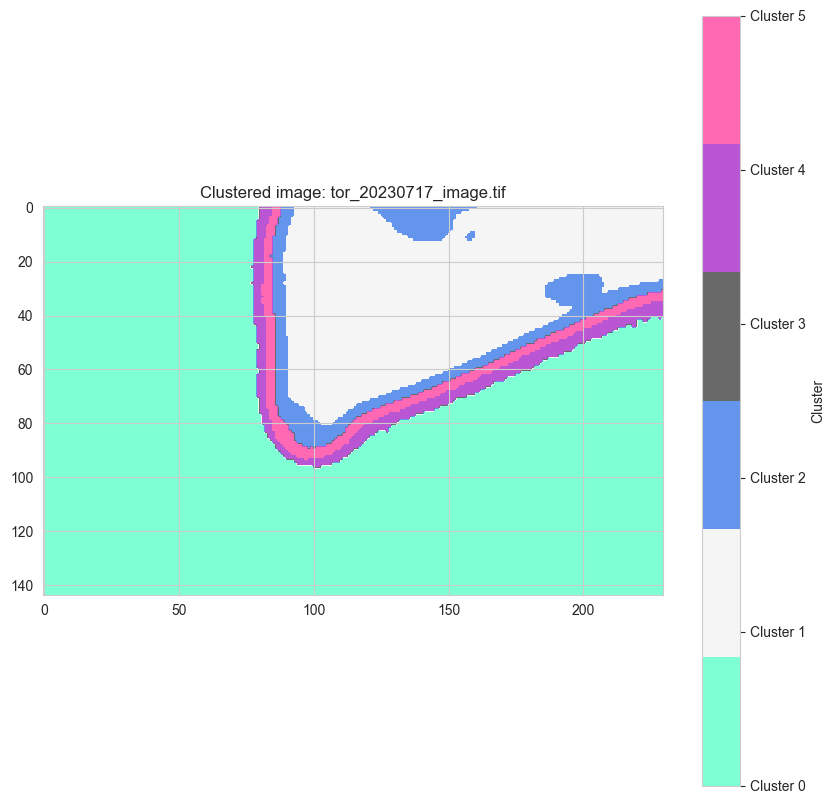

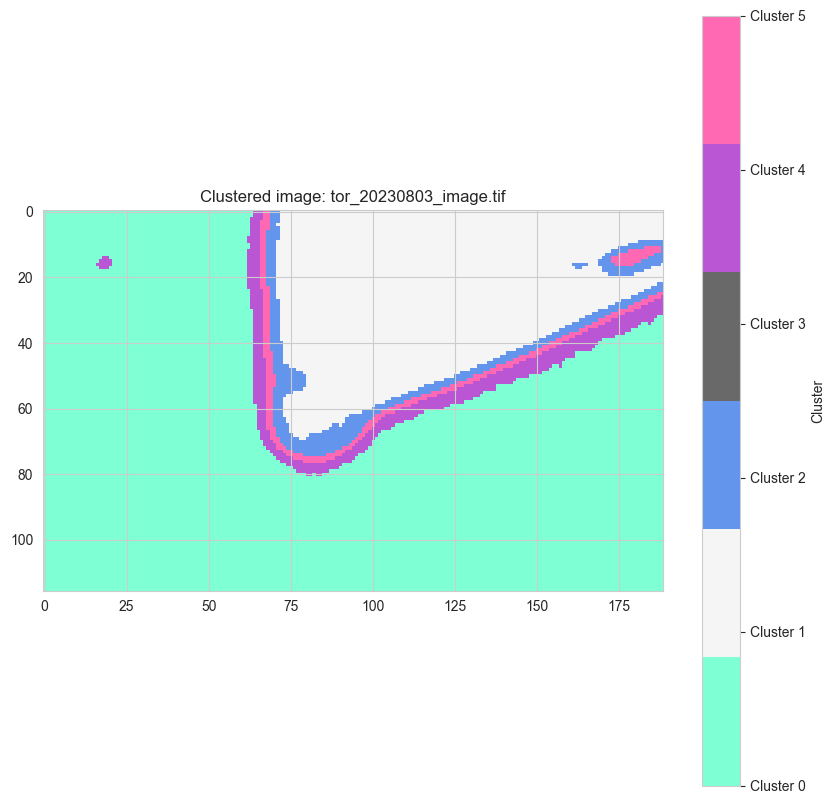

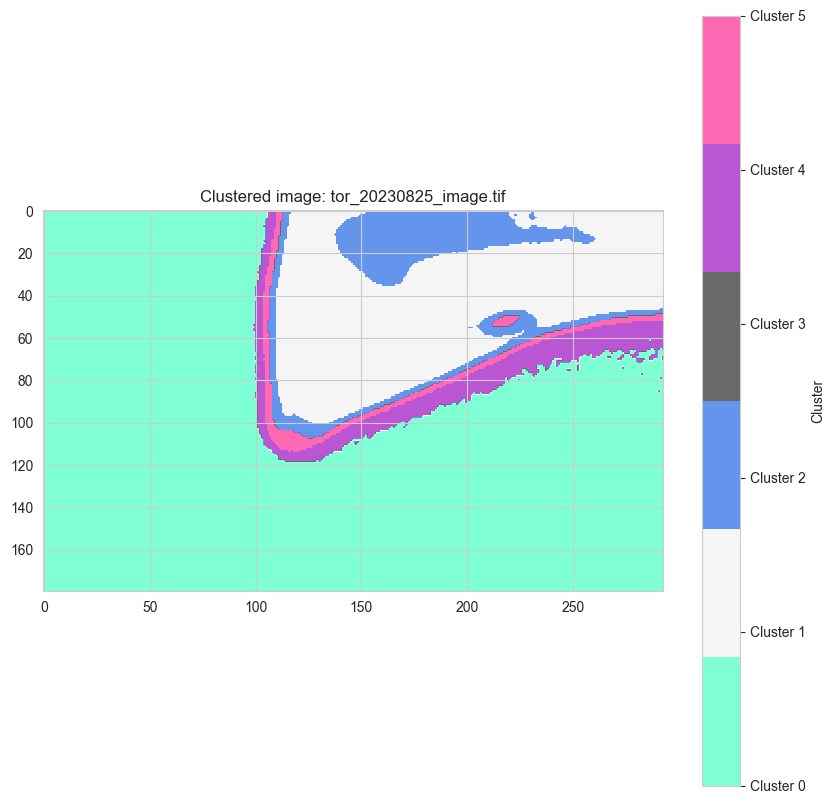

Tentative cluster to class mapping:
Cluster 4: ocean
Cluster 5: freshwater
Cluster 0: ocean
Cluster 3: ice
Cluster 1: freshwater
Cluster 2: ice


In [25]:
# Define a color map for the clusters
cluster_colors = ['aquamarine', 'whitesmoke', 'cornflowerblue', 'dimgrey', 'mediumorchid', 'hotpink']
cmap = mcolors.ListedColormap(cluster_colors[:n_clusters])

# Plot the clustered images
for image_path, predicted_image in predicted_images.items():
    plt.figure(figsize=(10, 10))
    plt.title(f"Clustered image: {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=n_clusters-1)
    
    cbar = plt.colorbar(ticks=range(n_clusters), label='Cluster')
    cbar.ax.set_yticklabels([f'Cluster {i}' for i in range(n_clusters)])
    
    plt.show()

# Optional: Try to match clusters to original classes
# This is a simple approach and may not be accurate
cluster_to_class = {}
for image_path, shapefile_paths in file_pairs.items():
    predicted_image = predicted_images[image_path]
    
    general_shapefile, walrus_shapefile = shapefile_paths
    if general_shapefile:
        gdf = gpd.read_file(general_shapefile)
        transform = rasterio.open(image_path).transform
        mask = geometry_mask([polygon for polygon in gdf['geometry']], 
                             out_shape=predicted_image.shape, 
                             transform=transform, invert=True)
    
        for label in gdf['label'].unique():
            label_mask = gdf['label'] == label
            label_pixels = predicted_image[mask & geometry_mask([polygon for polygon in gdf.loc[label_mask, 'geometry']], 
                                                                out_shape=predicted_image.shape, 
                                                                transform=transform, invert=True)]
            if len(label_pixels) > 0:
                most_common_cluster = np.bincount(label_pixels).argmax()
                if most_common_cluster not in cluster_to_class:
                    cluster_to_class[most_common_cluster] = label

print("Tentative cluster to class mapping:")
for cluster, label in cluster_to_class.items():
    print(f"Cluster {cluster}: {label}")